In [1]:
import json
import copy

import numpy
import matplotlib
from matplotlib import pyplot
import pyhf

import blind
import jsongz

In [2]:
import jax
import scipy.optimize

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

In [3]:
SPEC = jsongz.load("ins1852821_bkg.json.gz")
# SPEC = jsongz.load("ins1852821_signal.json.gz")

In [4]:
[channel["name"] for channel in SPEC["channels"]]

['SR0bvetoloose_cuts',
 'SR0bvetotight_cuts',
 'SR0breq_cuts',
 'SR1bvetoloose_cuts',
 'SR1bvetotight_cuts',
 'SR1breq_cuts',
 'SR2bvetoloose_cuts',
 'SR2bvetotight_cuts',
 'SR2breq_cuts',
 'SR0ZZloose_cuts',
 'SR0ZZtight_cuts',
 'SR0ZZbvetoloose_cuts',
 'SR0ZZbvetotight_cuts',
 'SR5L_cuts',
 'CRZZ_cuts',
 'CRttZ_cuts']

In [5]:
# SR_NAME = "SR0bvetotight_cuts"
# SR_NAME = "SR0ZZloose_cuts"
# SR_NAME = "SR0ZZtight_cuts"
SR_NAME = "SR0ZZbvetotight_cuts"
# atlas_susy_4l presents yields without SR constraints
# (sensibly, but violating ATLAS SUSY policy)

In [6]:
def get_named(seq, name):
    for item in seq:
        if item["name"] == name:
            return item
    raise KeyError(name)

In [7]:
def add_signal(
    spec,
    channel_name,
    measurement_name="NormalMeasurement",
    poi_name="mu_SIG",
):
    # add a dummy signal to its channel
    channel = get_named(spec["channels"], channel_name)

    channel["samples"].append({
        "data": [0.0],
        "modifiers": [{
            "data": None,
            "name": poi_name,
            "type": "normfactor", 
        }],
        "name": "signal",
    })
    
    # add a its modifier name to the measurement
    measurement = get_named(spec["measurements"], measurement_name)
    measurement["config"]["parameters"].append({
        "bounds": [[0.0, 2.0]],
        "fixed": False,
        "inits": [1.0],
        "name": poi_name,
    })
    measurement["config"]["poi"] = poi_name
    
    return spec

In [8]:
def make_model_and_data(spec, signal_channel_name):
    spec = copy.deepcopy(spec)
    spec = add_signal(spec, signal_channel_name)
    workspace = pyhf.workspace.Workspace(spec)
    
    channels_keep = {
        signal_channel_name,
        # TODO arguments?
        "CRZZ_cuts",
        "CRttZ_cuts",
    }
        
    channels_prune = workspace.channel_slices.keys() - channels_keep
    
    workspace_pruned = workspace.prune(channels=channels_prune)
    
    model = workspace_pruned.model()
    data = numpy.array(workspace_pruned.data(model))
    
    return model, data


MODEL, DATA = make_model_and_data(SPEC, SR_NAME)

In [9]:
def test_logpdf(model, data, signal_channel_name):
    parameters = numpy.array(model.config.suggested_init())
    
    print(model.logpdf(parameters, data))
    
    print(blind.model_logpdf_blind(model, parameters, data, []))
    
    logf = blind.model_logpdf_blind(model, parameters, data, {signal_channel_name})
    print(logf)

    slice_ = model.config.channel_slices[signal_channel_name]
    expected_data = model.expected_actualdata(parameters)
    mu = expected_data[slice_]
    nobs = data[slice_]
    print(mu, nobs)

    loglikelihood = pyhf.probability.Poisson(mu).log_prob(numpy.array(nobs))
    print(loglikelihood)
    print(logf + loglikelihood)


test_logpdf(MODEL, DATA, SR_NAME)

[-104.78063595]
[-104.78063595]
[-103.77680296]
[1.09012933] [1.]
[-1.00383299]
[-104.78063595]


In [10]:
def test_hess():
    def f(x):
        return 0.5 * x ** 2
    
    print(jax.hessian(f)(0.1))
    
test_hess()

1.0


In [11]:
def inner_product(x, c):
    return x.dot(c.dot(x))

In [12]:
def d2fdx2(fminus, f, fplus, eps):
    return ((fplus - f) - (f - fminus)) / eps ** 2

In [13]:
def test_opt(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    print(fjit(parameters)[0])

    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
        options=dict(ftol=1e-10, gtol=1e-10),
    )
    
    print(result)
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    print(y(parameters))
    print(y(result.x))
    
    ygrad = jax.grad(y)(result.x)
    
    def cov_jax(x):
        hess = jax.hessian(f)(x)
        return jax.numpy.linalg.inv(hess)
    
    cov_lbfgs = result.hess_inv.todense()
    cov = numpy.array(cov_jax(result.x))
    
    var_lbfgs = inner_product(ygrad, result.hess_inv)
    var = inner_product(ygrad, cov)
    
    print("std")
    print(var_lbfgs ** 0.5)
    # jax hessian seems to give broken answers - numerical failure?
    print(var ** 0.5)


test_opt(MODEL, DATA, SR_NAME)

103.77680296414808
      fun: 81.96411882730709
 hess_inv: <99x99 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.67974307e-04,  0.00000000e+00,  1.11821704e-05,  2.67221794e-05,
        1.26129820e-08,  4.65504360e-06,  5.16967445e-06,  2.01416918e-06,
       -6.06456655e-06, -7.47166516e-06, -6.85248382e-07,  3.29060185e-06,
       -4.77106286e-07, -3.99473868e-05,  7.31663886e-06, -7.99470629e-06,
       -1.84318515e-06,  1.73193817e-04,  3.55301480e-05,  2.49829705e-06,
        2.20235801e-07, -4.75640688e-08,  3.14516485e-05, -2.08643019e-05,
        1.90888362e-05,  6.28668213e-06,  1.48971380e-05,  0.00000000e+00,
        4.18147744e-06,  4.02328480e-06, -1.02958925e-06,  1.89218736e-05,
        3.01258596e-08, -9.02388942e-07,  3.03691338e-06, -1.11365458e-05,
       -6.85990503e-06, -1.22898568e-05,  1.92619439e-06, -3.25148294e-06,
        1.27844981e-05, -4.48682908e-06, -6.74086475e-06, -7.12281639e-06,
        1.95529861e-05,  2.30696701e-07, -1.25362685e-04, 

# optimize with constraints

In [14]:
def piecewise_linear_roots(f, x):
    """Return a list of points for which f(x) = 0 in a linear interpolation."""
    results = []
    for f1, f2, x1, x2 in zip(f[:-1], f[1:], x[:-1], x[1:]):
        # root implies that f1 f2 change sign
        if not f1 * f2 <= 0:
            continue
        # zero step special case
        if x1 == x2:
            if f1 == 0:
                results.append(x1)
            continue
        # zero change special case
        if f1 == f2:
            if f1 == 0:
                # panic! entire line segment is a root
                results.append(numpy.nan)
            continue
        # approx f = f1 + (x - x1) * (f2 - f1) / (x2 - x1)
        #          = f1 + (x - x1) * dfdx
        # f = 0 =>
        #        x = x1 + (0 - f1) / dfdfx
        xroot = x1 - f1 * (x2 - x1) / (f2 - f1)
        results.append(xroot)
    return results

f =  81.96411882989364
y =  1.104122290487657
f =  87.34875176568336
y =  4.000000022923318


/home/tombs/Cambridge/interval-evidence/env/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0.1 98.45349890241918
0.22250000000000003 95.39578145184863
0.34500000000000003 90.07264903212555
0.4675 86.05665813245855
0.5900000000000001 83.95562227368008
0.7125 82.85185177198963
0.8350000000000001 82.29540137792921
0.9575 82.04454903361184
1.08 81.96595220346221
1.2025000000000001 81.99043106047242
1.3250000000000002 82.08066936441547
1.4475000000000002 82.21525306297869
1.5700000000000003 82.38105706689329
1.6925000000000003 82.56956344690371
1.8150000000000002 82.77499496689671
1.9375000000000002 82.99330481952026
2.06 83.2215984447918
2.1825 83.45776746666574
2.305 83.70025599709926
2.4275 83.94789335860594
2.5500000000000003 84.19978829768182
2.6725000000000003 84.45524286049732
2.7950000000000004 84.71370722649964
2.9175000000000004 84.97473430117758
3.0400000000000005 85.23795751761574
3.1625000000000005 85.50306902295381
3.2850000000000006 85.76980754119899
3.4075 86.03794664505614
3.5300000000000002 86.30728701311685
3.6525000000000003 86.57764963981839
3.775000000000000

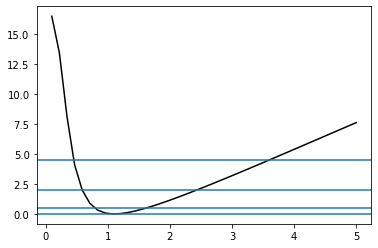

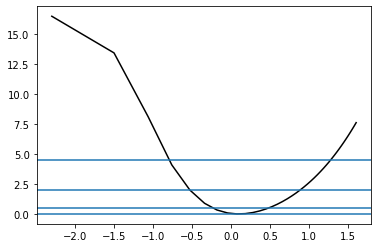

[0.7978576274071287, 1.623977302874203]


In [15]:
def test_opt_constrain(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    # optimization
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
    )
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    yjit = jax.jit(y)
    
    print("f = ", result.fun)
    print("y = ", yjit(result.x))
    
    # constrain
    ygrad = jax.jit(jax.grad(y))
    
    yfix = 4.0
    fix = scipy.optimize.NonlinearConstraint(y, yfix, yfix, jac=ygrad)
        
    result2 = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="SLSQP",
        constraints=fix,
    )

    print("f = ", result2.fun)
    print("y = ", yjit(result2.x))
    
    x0test = result.x
    
    # scan
    def fmax_given_yfix(yfix):
        fix = scipy.optimize.NonlinearConstraint(
            y, 
            yfix, 
            yfix, 
            jac=ygrad,
        )

        result = scipy.optimize.minimize(
            fjit,
            x0test,
            bounds=bounds,
            jac=True,
            method="SLSQP",
            constraints=fix,
        )
        
        return result.fun
    
    ypoints = numpy.linspace(0.1, 5., 41)
    
    fs = []
    for yfix in ypoints:
        fmax = fmax_given_yfix(yfix)
        print(yfix, fmax)
        fs.append(fmax)
        
    fs = numpy.array(fs)
    
    pyplot.plot(ypoints, fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.plot
    pyplot.show()   
    
    pyplot.plot(numpy.log(ypoints), fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.plot
    pyplot.show()
    
    print(piecewise_linear_roots(fs - result.fun - 0.5, ypoints))
        


test_opt_constrain(MODEL, DATA, SR_NAME)

In [16]:
def print_fit_stuff():
    lo, hi = 0.9312021701411659, 1.609647706302541
    mid = 1.104122290487657
    
    err_lo = mid - lo
    err_hi = hi - mid
    print("%.1f +%.1f -%.1f" % (mid, err_lo, err_hi))

print_fit_stuff()

1.1 +0.2 -0.5
